In [59]:
using LinearAlgebra
# examples from https://www.math.uci.edu/~ttrogdon/105A/html/Lecture23.html

In [60]:
function householder_hessenberg(A :: Matrix{Float64})
  H = copy(A)
  N = size(A, 1)
  for i=1:N-2
    α = H[i+1:N, i] # FIXME
    σ = norm(α)
    β = 1.0  / (σ * (σ + abs(α[1])))
    expjϕ = α[1] < 0.0 ? -1.0 : 1.0 
    u = copy(α)
    u[1] = expjϕ * (σ + abs(α[1]))
    T = diagm(ones(N))
    T[i+1:N, i+1:N] .= diagm(ones(length(α))) - β * u * u'
    H .= T * H * T
  end
  return H
end

householder_hessenberg (generic function with 1 method)

In [3]:
using SparseArrays
dropalmostzeros(A, ϵ) = sparse([abs(aij) > ϵ ? aij : 0.0 for aij in A])

dropalmostzeros (generic function with 1 method)

In [4]:
A = rand(5, 5)
A*= A'
H = householder_hessenberg(A)
dropalmostzeros(H, 1e-15)

5×5 SparseMatrixCSC{Float64, Int64} with 13 stored entries:
  2.13598  -2.90952    ⋅          ⋅          ⋅ 
 -2.90952   5.69189   1.08024     ⋅          ⋅ 
   ⋅        1.08024   0.925568  -0.074032    ⋅ 
   ⋅         ⋅       -0.074032   0.648886  -0.097627
   ⋅         ⋅         ⋅        -0.097627   0.0856877

In [5]:
function householder_qr(A :: Matrix{Float64})
  R = copy(A)
  N = size(A, 1)
  Q = diagm(ones(N))
  for i=1:size(A, 2)
    α = R[i:N, i]
    σ = norm(α)
    β = 1.0  / (σ * (σ + abs(α[1])))
    expjϕ = α[1] < 0.0 ? -1.0 : 1.0 
    u = copy(α)
    u[1] = expjϕ * (σ + abs(α[1]))
    T = diagm(ones(N))
    T[i:N, i:N] .= diagm(ones(length(α))) - β * u * u'
    R = T * R # te linie zostały zmienione
    Q = Q * T # względem metody Householdera zdefiniowanej wcześniej
  end
  return Q, R
end

householder_qr (generic function with 1 method)

In [6]:
using LinearAlgebra
function givensrot(A, i, j)
  q = sqrt(A[j,j]^2 + A[i,j]^2);
  c = A[j,j] / q;
  s = A[i,j] / q;
  N = size(A, 1);
  G = diagm(ones(N));
  G[i,i] = c; G[j,j] = c;
  G[j,i] = s; G[i,j] =-s;
  return G
end

givensrot (generic function with 1 method)

In [127]:
G1 = let α = -π/4 # clock-wise rotation
    c, s = cos(α), sin(α)
   [1 0 0  0
    0 1 0  0
    0 0 c -s
    0 0 s  c]
end


4×4 Matrix{Float64}:
 1.0  0.0   0.0       0.0
 0.0  1.0   0.0       0.0
 0.0  0.0   0.707107  0.707107
 0.0  0.0  -0.707107  0.707107

In [128]:
sqrt(3)/2

0.8660254037844386

In [129]:

G2 = let α = -π/3 # clock-wise rotation
    c, s = cos(α), sin(α)
   [c 0 0 -s
    0 1 0  0
    0 0 1  0
    s 0 0  c]
end

4×4 Matrix{Float64}:
  0.5       0.0  0.0  0.866025
  0.0       1.0  0.0  0.0
  0.0       0.0  1.0  0.0
 -0.866025  0.0  0.0  0.5

In [130]:
G = G1 * G2

4×4 Matrix{Float64}:
  0.5       0.0   0.0       0.866025
  0.0       1.0   0.0       0.0
 -0.612372  0.0   0.707107  0.353553
 -0.612372  0.0  -0.707107  0.353553

In [136]:
G = [0.5 0 0 sqrt(3)/2;
     0    1 0 0;
    -sqrt(3)/sqrt(8) 0  1/sqrt(2) 1/sqrt(8);
    -sqrt(3)/sqrt(8) 0 -1/sqrt(2) 1/sqrt(8)]

4×4 Matrix{Float64}:
  0.5       0.0   0.0       0.866025
  0.0       1.0   0.0       0.0
 -0.612372  0.0   0.707107  0.353553
 -0.612372  0.0  -0.707107  0.353553

In [141]:
G = [1/2 0 sqrt(3/4); -sqrt(3/8) sqrt(1/2) sqrt(1/8); -sqrt(3/8) -sqrt(1/2) sqrt(1/8)]

3×3 Matrix{Float64}:
  0.5        0.0       0.866025
 -0.612372   0.707107  0.353553
 -0.612372  -0.707107  0.353553

In [142]:
dropalmostzeros(G' * G, 1e-15)

3×3 SparseMatrixCSC{Float64, Int64} with 3 stored entries:
 1.0   ⋅    ⋅ 
  ⋅   1.0   ⋅ 
  ⋅    ⋅   1.0

In [7]:
function francis(A :: Matrix{Float64}, maxiter)
  H = householder_hessenberg(A)
  N = size(H, 1)
  G = [[0. 0.; 0. 0.] for j=1:N-1]
  λs = zeros(N)
  for k = 1:maxiter
    @show "before"
    display(dropalmostzeros(H,1e-15))
    for j = 1:N-1
      q = sqrt(H[j,j]^2 + H[j+1,j]^2);
      c = H[j,  j] / q;
      s = H[j+1,j] / q;
      G[j] = [c -s; +s c]
      H[j:j+1, j:N] = G[j]' * H[j:j+1, j:N] # => 2 x (N-j)
    end
    @show "during"
    display(dropalmostzeros(H,1e-15))
    for j = 1:N-1
      H[1:j+1, j:j+1] = H[1:j+1, j:j+1] * G[j] # (j) x 2
    end
    @show "after"
    display(dropalmostzeros(H,1e-15))
    λs .= diag(H)
  end
  @show "final"
  display(dropalmostzeros(H, 1e-15))
  return λs
end

francis (generic function with 1 method)

In [8]:
francis(A, 1)

"before" = "before"


5×5 SparseMatrixCSC{Float64, Int64} with 13 stored entries:
  2.13598  -2.90952    ⋅          ⋅          ⋅ 
 -2.90952   5.69189   1.08024     ⋅          ⋅ 
   ⋅        1.08024   0.925568  -0.074032    ⋅ 
   ⋅         ⋅       -0.074032   0.648886  -0.097627
   ⋅         ⋅         ⋅        -0.097627   0.0856877

"during" = "during"


5×5 SparseMatrixCSC{Float64, Int64} with 12 stored entries:
 3.6094  -6.31002  -0.870779    ⋅           ⋅ 
  ⋅       1.48778   1.1116    -0.0537528    ⋅ 
  ⋅        ⋅        0.187509  -0.302962    0.038545
  ⋅        ⋅         ⋅         0.584285   -0.102752
  ⋅        ⋅         ⋅          ⋅          0.0694961

"after" = "after"


5×5 SparseMatrixCSC{Float64, Int64} with 13 stored entries:
  7.22247  -1.19929     ⋅          ⋅           ⋅ 
 -1.19929   1.41252    0.136146    ⋅           ⋅ 
   ⋅        0.136146   0.238074  -0.230687     ⋅ 
   ⋅         ⋅        -0.230687   0.54644    -0.0116119
   ⋅         ⋅          ⋅        -0.0116119   0.0685191

"final" = "final"


5×5 SparseMatrixCSC{Float64, Int64} with 13 stored entries:
  7.22247  -1.19929     ⋅          ⋅           ⋅ 
 -1.19929   1.41252    0.136146    ⋅           ⋅ 
   ⋅        0.136146   0.238074  -0.230687     ⋅ 
   ⋅         ⋅        -0.230687   0.54644    -0.0116119
   ⋅         ⋅          ⋅        -0.0116119   0.0685191

5-element Vector{Float64}:
 7.2224721472163385
 1.4125160329730597
 0.2380742156555486
 0.5464396411028218
 0.06851907745268761

In [9]:
dropalmostzeros(R, 1e-15)

LoadError: UndefVarError: `R` not defined

In [110]:
Q = diagm(ones(5));
R = [1.00 1.00 1.50; 0 0.5 1.5; 0 0 2.5; 0 0 0; 0 0 0];

In [111]:
dropalmostzeros(R, 1e-15)

5×3 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 1.0  1.0  1.5
  ⋅   0.5  1.5
  ⋅    ⋅   2.5
  ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅ 

In [112]:
dropalmostzeros(Q, 1e-15)

5×5 SparseMatrixCSC{Float64, Int64} with 5 stored entries:
 1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0

In [109]:
A = Q * R

5×3 Matrix{Float64}:
 1.0  1.0  1.5
 0.0  0.5  1.5
 0.0  0.0  2.5
 0.0  0.0  0.0
 0.0  0.0  0.0

In [98]:
x = [2.5 3.0 -1.0]'
b = (Q * R) * x

5×1 Matrix{Float64}:
  4.0
  0.0
 -2.5
  0.0
  0.0

In [99]:
R1 = R[1:3, :]
Q1 = Q[:, 1:3]
R1 \ (Q1' * b)

3×1 Matrix{Float64}:
  2.5
  3.0
 -1.0

In [100]:
x

3×1 adjoint(::Matrix{Float64}) with eltype Float64:
  2.5
  3.0
 -1.0

In [14]:
# Naïve Krylov solver (uses {b, Ab, A^2b, A^3b, ...})
function naïvekrylov(A, b, maxiter, epsilon)
    K = b;
    x = similar(b)
    history = Float64[]
    for k = 1:maxiter
        # solve least squares problem
        # minimize norm( (A*K) y - b)
        AK = A*K
        println(k, ") A*K = ", size(AK))
        y = AK \ b;
        # find the minimal residual
        # note that: x =  K * y
        x .= K * y;
        push!(history, norm(b - AK * y));
        if history[k] < epsilon
            break
        end
        # extend our Krylov subspace
        K = hcat(K, AK[:, k]);
    end
    println("Maximum number of iterations reached")
    return x, history
end

naïvekrylov (generic function with 1 method)

In [15]:
A = randn(150, 150) + 150.0diagm(ones(150));
b = ones(150);
x, res = naïvekrylov(A, b, 15, 1e-7); # naive Krylov method
norm(A * x - b)

1) A*K = (150,)
2) A*K = (150, 2)
3) A*K = (150, 3)
4) A*K = (150, 4)
5) A*K = (150, 5)
6) A*K = (150, 6)
7) A*K = (150, 7)
8) A*K = (150, 8)
9) A*K = (150, 9)
10) A*K = (150, 10)
11) A*K = (150, 11)
12) A*K = (150, 12)
13) A*K = (150, 13)
14) A*K = (150, 14)
15) A*K = (150, 15)
Maximum number of iterations reached


0.09558211850022368

In [16]:
function givens_qr(A)
    N = size(A, 1)
    Q = diagm(ones(N))
    R = copy(A)
    
    for i=1:N-1
        for j=i+1:N
            G = givensrot(R, j, i)
            Q = Q * G'
            R = G * R
        end
    end
    return Q, R
end

givens_qr (generic function with 1 method)

In [17]:
A = rand(5, 5)
Q, R = givens_qr(A)
R

5×5 Matrix{Float64}:
  1.10999       0.561264      1.00955       1.48389      0.901675
  1.25377e-17   0.272121      0.506605      0.368201     0.402256
 -1.65149e-17   3.90452e-18   0.506639     -0.140711     0.692327
  5.05996e-18  -1.19166e-17   5.32973e-18   0.552106     0.482002
 -1.65518e-17   5.49601e-18  -9.9868e-18    1.37465e-17  0.24766

In [18]:
q, r = householder_qr(A)
r

5×5 Matrix{Float64}:
 -1.10999      -0.561264     -1.00955      -1.48389      -0.901675
  4.9374e-17   -0.272121     -0.506605     -0.368201     -0.402256
 -6.71813e-18  -1.90756e-18   0.506639     -0.140711      0.692327
 -1.20353e-18  -3.91922e-17   2.40502e-18  -0.552106     -0.482002
  4.27211e-17   1.37144e-17   2.11497e-17  -1.85967e-18   0.24766

In [19]:
A = rand(3,3)

A1 = copy(A)
G1 = givensrot(A1, 2, 1); A2 = G1 * A1
G2 = givensrot(A2, 3, 1); A3 = G2 * A2
G3 = givensrot(A3, 3, 2); A4 = G3 * A3

dropalmostzeros(A4, 1e-15)

3×3 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 1.38747  0.529741  0.78951
  ⋅       0.396235  0.408393
  ⋅        ⋅        0.367748

In [20]:
Q = (G1' * G2' * G3')
dropalmostzeros(Q' * Q, 1e-15)

3×3 SparseMatrixCSC{Float64, Int64} with 3 stored entries:
 1.0   ⋅    ⋅ 
  ⋅   1.0   ⋅ 
  ⋅    ⋅   1.0

In [21]:
R = (G3 * (G2 * (G1 * A)))
dropalmostzeros(R, 1e-15)

3×3 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 1.38747  0.529741  0.78951
  ⋅       0.396235  0.408393
  ⋅        ⋅        0.367748

In [22]:
dropalmostzeros(Q * R - A, 1e-15)

3×3 SparseMatrixCSC{Float64, Int64} with 0 stored entries:
  ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅ 

In [23]:
# Iteracja Arnoldiego pozwala na wyznaczenie wektora
# ortogonalnego do wektorów z bazy Q
# wykorzystując proces podobny do metody Gramma-Schmidta
# źródło: [3]
function arnoldi_iteration(A, Q, k)
    q = A * Q[:,k];
    h = zeros(k+1);
    for j=1:k
        h[j] = dot(Q[:, j], q);
        q = q - h[j] * Q[:, j]; 
    end
    h[k+1] = norm(q);
    q = q / h[k+1];
    return q, h
end
# GMRES
function gmres(A, b, maxiter, epsilon)
    N  = size(A, 1);
    x0 = zeros(N, 1);
    r0 = b - A * x0;
    β  = norm(r0);
    e1 = [1.0; zeros(maxiter, 1)]; # MAXITER × 1
    H = zeros(maxiter, maxiter);    # MAXITER × MAXITER
    Q = zeros(N, maxiter);               #  N × MAXITER
    Q[:, 1] .= r0 / β;
    G = diagm(ones(maxiter)); # MAXITER × MAXITER
    history = Float64[]
    y = zeros(0)
    for k=1:maxiter-1
        # find next orthogonal vector
        qkp, hkp = arnoldi_iteration(A, Q, k);
        Q[:, k+1] .= qkp
        H[1:k+1,k].= hkp 
        # update Given's rotation matrix
        Gi = givensrot(G * H, k+1, k);
        G  = Gi * G;
        # solve least squares problem:
        # minimize norm([U; 0] y - [F; e])
        U = G[1:k, 1:k+1] * H[1:k+1, 1:k];
        F = G[1:k, 1:k+1] * β * e1[1:k+1];
        e = G[k+1, 1:k+1]'* β * e1[1:k+1];
        y = U \ F;
        Kn = H[1:k+1,1:k] # Krylov subspace
        Un = U[1:k,  1:k]
        push!(history, abs(e))
        if abs(e) < epsilon
            break
        end
    end
    k = length(y)
    x = x0 + Q[:, 1:k] * y;
    D = Q[:, 1:k];
    return x, history
end

gmres (generic function with 1 method)

In [56]:
function fdmproblem(n)
    m = n
    A = zeros(n*m, n*m)
    dof = reshape(1:n*m, n, m)
    for i=2:n, j=1:m
        A[dof[i,j], dof[i-1,j]] -= 1.0
        A[dof[i,j], dof[i,j]] += 1.0
    end
    for i=1:n, j=2:m
        A[dof[i,j], dof[i,j-1]] -= 1.0
        A[dof[i,j], dof[i,j]] += 1.0
    end
    for i=1:n-1, j=1:m
        A[dof[i,j], dof[i+1,j]] -= 1.0
        A[dof[i,j], dof[i,j]] += 1.0
    end
    for i=1:n, j=1:m-1
        A[dof[i,j], dof[i,j+1]] -= 1.0
        A[dof[i,j], dof[i,j]] += 1.0
    end
    for i=(1,n), j=1:m
        A[dof[i,j], :] .= 0.0
        A[dof[i,j], dof[i,j]] = 1.0
    end
    for i=1:n, j=(1,m)
        A[dof[i,j], :] .= 0.0
        A[:, dof[i,j]] .= 0.0
        A[dof[i,j], dof[i,j]] = 1.0
    end    
    x = zeros(n*m)
    for i=1:n, j=1:m
        x[dof[i,j]] += sin(1.0π * (i-1)/(n-1))
        x[dof[i,j]] += sin(1.0π * (j-1)/(m-1))
    end
    b = A * x
    free = vec([dof[i, j] for i=2:n-1, j=2:m-1])
    return sparse(A[free, free]), b[free]
end
A, b = fdmproblem(100);

In [57]:
x, fdm = gmres(A, b, 300, 1e-17)

([0.032635433376150984; 0.06520788584861216; … ; 0.06520788584861302; 0.032635433376152045;;], [4.462445782372392, 2.674672108828486, 1.8351525851766741, 1.3634837722586668, 1.0682483795998214, 0.8695577875827714, 0.7287021606557018, 0.6248612567615413, 0.5459338581603016, 0.4844509157464235  …  7.571099447547526e-14, 7.571099447547497e-14, 7.571099447547466e-14, 7.57109944754744e-14, 7.571099447547412e-14, 7.571099447547385e-14, 7.571099447547356e-14, 7.571099447547329e-14, 7.571099447547296e-14, 7.571099447547257e-14])

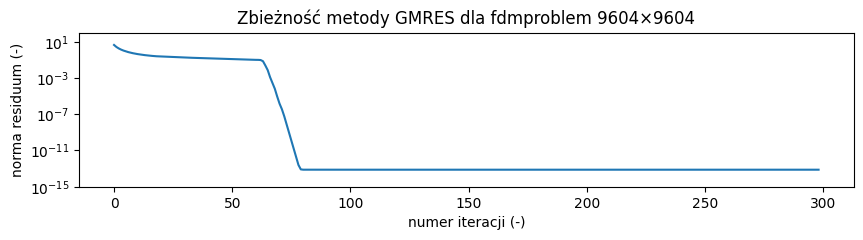

PyObject Text(0.5, 1.0, 'Zbieżność\xa0metody GMRES dla fdmproblem 9604×9604')

In [58]:
using PyPlot
figure(figsize=(10, 2))
semilogy(fdm)
ylim((1e-15, 1e+2))
xlabel("numer iteracji (-)")
ylabel("norma residuum (-)")
title("Zbieżność metody GMRES dla fdmproblem $(length(b))×$(length(b))")

In [51]:
using LinearAlgebra
using SparseArrays

stiffness_element(lx, ly) =
[lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx
 lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx]

mass_element(lx, ly) = (lx * ly) / 6.0 *
[ 2. 0 -1  0
  0  2  0 -1
 -1  0  2  0
  0 -1  0  2]

function assemble!(S, R, T, el2ed, el2edd, dof, lx, ly, nelem, ndof; εr=1, μr=1, ε0=8.854e-12, μ0=4e-7π)
  # ASSUMPTION: Waveguide is homogenous
  # Assemble stiffness and mass matrices
  ε = εr*ε0
  for ielem = 1:nelem # Assemble by elements
    Se = stiffness_element(lx, ly)
    Te = mass_element(lx, ly)
    
    for jedge = 1:4
      dj = el2edd[ielem, jedge]
      jj = dof[el2ed[ielem, jedge]]
      if jj == 0
        continue
      end
      
      for kedge = 1:4
        dk = el2edd[ielem, kedge]
        kk = dof[el2ed[ielem, kedge]]
        if kk == 0
          continue
        end
  
        S[jj, kk] = S[jj, kk] + dj * dk * (1/μr) * Se[jedge, kedge]
        T[jj, kk] = T[jj, kk] + dj * dk * (μ0*ε) * Te[jedge, kedge]
      end
    end
  end
  return nothing
end

function lhs(S, T, R, Δt)
  A = (+0.25Δt^2 * S +  T + 0.5Δt * R)
end

function rhs(S, T, R, Δt, ep, epp)
  b = (-0.25Δt^2 * S -  T + 0.5Δt * R) * epp +
      (-0.50Δt^2 * S + 2T) * ep
end

function quadmesh(a, b, Nx, Ny)
    NUM_EDGES = 2(Nx*Ny) + Nx + Ny
    NUM_ELEMS = Nx * Ny
    
    el2edd = repeat([+1 +1 -1 -1], NUM_ELEMS)
    el2ed = zeros(Int64, NUM_ELEMS, 4)
    for jj = 1:Ny
        for ii = 1:Nx
            kk = (jj-1)Nx + ii
            el2ed[kk, :]  .= [ii, ii+Nx+1, ii+Nx+1+Nx, ii+Nx]
            el2ed[kk, :] .+= (jj-1) * (Nx + Nx + 1)
        end
    end

    return el2ed, el2edd, NUM_EDGES
end

function femproblem(n)
    m = n
    @assert n * m < 40*40 "Are you sure? Try smaller problem first (n < 40)!"
    
    # parameters
    Δt = 0.01e-9
    Lx = 2.00
    Ly = 2.00
    lx = Lx / n
    ly = Ly / m
    el2ed, el2edd, nedge = quadmesh(Lx, Ly, n, m);
    
    # degrees of freedom
    DOF_NONE = 0
    DOF_PEC  = 1

    h = [  1+(2n+1)i: n+0+(2n+1)i for i=0:m]
    v = [n+1+(2n+1)i:2n+1+(2n+1)i for i=0:m-1]

    Γ = zeros(Int64, nedge)
    Γ[first(h)] .= DOF_PEC
    Γ[last(h)]  .= DOF_PEC
    for i=1:m
         Γ[first(v[i])] = DOF_PEC
         Γ[last(v[i])] = DOF_PEC
    end

    dof = collect(1:nedge)
    free = Γ .!= DOF_PEC

    # assemble finite element matrices
    S = zeros(nedge, nedge)
    T = zeros(nedge, nedge)
    R = zeros(nedge, nedge)
    assemble!(S, T, R, el2ed, el2edd, dof, lx, ly, n*m, nedge)
    
    # construct the problem left hand side
    A = lhs(S[free, free], T[free, free], R[free, free], Δt);
    
    # calculate eigensolution and use it as a starting point
    k², v = eigen(Array(S[free, free]), Array(T[free, free]))
    
    e = zeros(nedge)
    ep = copy(e)
    epp = copy(e)
    ep[free] .= epp[free] .= v[:, 1+(n-1)*(m-1)]
    
    # construct the problem right hand side
    b = rhs(S[free, free], T[free, free], R[free, free], Δt, ep[free], epp[free])
    
    return 1e23sparse(A), 1e23b
end
A, b = femproblem(30);

In [52]:
x, fem = gmres(A, b, 300, 1e-17)

([1.7713042569237192e-5; 3.4850770247173646e-5; … ; 0.004886139265536557; -0.006893674383223846;;], [6.545442220264269, 2.477593335798485, 1.1561889927105067, 0.6222949934370734, 0.36750082403422035, 0.2340676291068107, 0.15633576167453608, 0.10865125602184367, 0.07780831008698127, 0.05739703840269362  …  1.8656227699311348e-10, 1.7723938834783207e-10, 1.674166989275424e-10, 1.6122632231494664e-10, 1.5899602742852889e-10, 1.585837657746694e-10, 1.585208319538666e-10, 1.5850233254368451e-10, 1.5849186114130948e-10, 1.5848209746503054e-10])

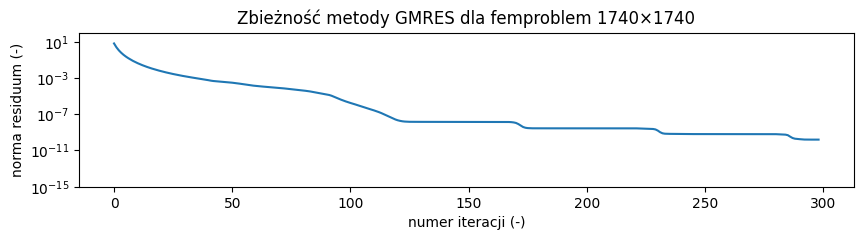

PyObject Text(0.5, 1.0, 'Zbieżność\xa0metody GMRES dla femproblem 1740×1740')

In [54]:
using PyPlot
figure(figsize=(10, 2))
semilogy(fem)
ylim((1e-15, 1e+2))
xlabel("numer iteracji (-)")
ylabel("norma residuum (-)")
title("Zbieżność metody GMRES dla femproblem $(length(b))×$(length(b))")

In [143]:
function cgs(A :: Matrix{Float64}) n, _ = size(A)
v = A[:,1]
Q = zeros(n, n)
for j = 1:n v = A[:,j]
for k = 1:j-1
v .-= (Q[:,k] ⋅ A[:,j]) * Q[:,k]
end
    Q[:,j] .= v ./ norm(v)
end
R = Q' * A
return Q, R end

cgs (generic function with 1 method)

In [144]:
function mgs(A :: Matrix{Float64}) n, _ = size(A)
v = A[:,1]
Q = zeros(n, n)
for j = 1:n v = A[:,j]
for k = 1:j-1
v .-= (Q[:,k] ⋅ v) * Q[:,k]
end
    Q[:,j] .= v ./ norm(v)
end
R = Q' * A
return Q, R end

mgs (generic function with 1 method)

In [150]:
A = floor.(10rand(3,3))

3×3 Matrix{Float64}:
 7.0  3.0  6.0
 2.0  5.0  9.0
 7.0  3.0  8.0

In [158]:
Q, R = mgs(A)
Q' * Q

3×3 Matrix{Float64}:
  1.0          -1.94289e-16  -1.11022e-16
 -1.94289e-16   1.0          -6.10623e-16
 -1.11022e-16  -6.10623e-16   1.0

In [169]:
v1 = [1., -1., 0]
v2 = [0, 0, 1]
v3 = [+1, 1., 0]
A = hcat(normalize(v1), normalize(v2), normalize(v3))

3×3 Matrix{Float64}:
  0.707107  0.0  0.707107
 -0.707107  0.0  0.707107
  0.0       1.0  0.0

In [184]:
A = hcat(v1, normalize(v2 - 2v1), normalize(v3 - v1))

3×3 Matrix{Float64}:
  1.0  -0.666667  0.0
 -1.0   0.666667  1.0
  0.0   0.333333  0.0

In [186]:
Q, R = cgs(A)
A' * A

3×3 Matrix{Float64}:
  2.0      -1.33333   -1.0
 -1.33333   1.0        0.666667
 -1.0       0.666667   1.0

In [198]:
R = [1. 1. 1.5; 0 0.5 1.5; 0. 0. 2.5]
Q = [1. 0 0; 0 1. 0; 0 0 1.]
b = [4., 0., -2.5]
R \ (Q * b)

3-element Vector{Float64}:
  2.5
  3.0
 -1.0

In [193]:
Q * b

3-element Vector{Float64}:
 0.33333333333333315
 0.6666666666666669
 0.3333333333333331